In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import re
import string
import nltk
from nltk.tokenize import wordpunct_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sentence_transformers import SentenceTransformer

In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 10.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import pandas as pd
import numpy as np
!pip install faiss-cpu

import faiss
import spacy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.7/30.7 MB 23.9 MB/s eta 0:00:00


In [ ]:
combined_df = pd.read_csv('combined_df_processed (1).csv')

In [ ]:
combined_df['combined_text'] = combined_df['Processed_Title'] + " " + combined_df['Processed_Abstract']

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Define our text processing functions
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def tokenize_text(text):
    return wordpunct_tokenize(text)

def remove_stopwords(tokens):
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

def lemmatize_tokens(tokens):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def preprocess_text(text):
    cleaned = clean_text(text)
    tokens = tokenize_text(cleaned)
    tokens = remove_stopwords(tokens)
    lemmatized = lemmatize_tokens(tokens)
    return ' '.join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(combined_df['combined_text']).toarray().astype(np.float32)

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
if 'bert_embeddings' not in combined_df.columns:
    print("Generating BERT embeddings...")
    combined_df['bert_embeddings'] = model.encode(combined_df['combined_text'].tolist(), show_progress_bar=True).tolist()
embeddings = np.stack(combined_df["bert_embeddings"].values).astype(np.float32)
faiss.normalize_L2(embeddings)
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating BERT embeddings...


Batches:   0%|          | 0/160 [00:00<?, ?it/s]

In [ ]:
spacyModel = spacy.load("en_core_web_md")
if 'spacy_embeddings' not in combined_df.columns:
    print("Generating spaCy embeddings...")
    combined_df['spacy_embeddings'] = combined_df['combined_text'].apply(lambda text: spacyModel(text).vector.tolist())
spacy_embeddings = np.stack(combined_df["spacy_embeddings"].values).astype(np.float32)
faiss.normalize_L2(spacy_embeddings)
d_spacy = spacy_embeddings.shape[1]
index_spacy = faiss.IndexFlatL2(d_spacy)
index_spacy.add(spacy_embeddings)

Generating spaCy embeddings...


In [ ]:
## user input = query string, preprocess it, vectorize it, and return the top_n most similar articles.
def search_articles(query, top_n=5):
    query_processed = preprocess_text(query)
    query_vector = vectorizer.transform([query_processed])

    similarities = cosine_similarity(query_vector, tfidf_matrix).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]

    return combined_df.iloc[top_indices]

def search_tfidf(query, top_n=5):
    query_processed = preprocess_text(query)
    query_vector = vectorizer.transform([query_processed]).toarray().astype(np.float32)

    index = faiss.IndexFlatL2(tfidf_matrix.shape[1])
    faiss.normalize_L2(tfidf_matrix)  # Normalize for cosine similarity
    index.add(tfidf_matrix)

    faiss.normalize_L2(query_vector)
    _, top_indices = index.search(query_vector, top_n)

    return combined_df.iloc[top_indices[0]]

def search_bert_cosine(query, top_n=5):
    query_embedding = model.encode(query).reshape(1, -1)
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]

    return combined_df.iloc[top_indices]

def search_bert_faiss(query, top_n=5):
    query_embedding = model.encode([query])
    faiss.normalize_L2(query_embedding)
    _, top_indices = index.search(query_embedding, top_n)

    return combined_df.iloc[top_indices[0]]

def search_spacy_cosine(query, top_n=5):
    query_embedding = spacyModel(query).vector.reshape(1, -1)
    similarities = cosine_similarity(query_embedding, spacy_embeddings).flatten()
    top_indices = similarities.argsort()[::-1][:top_n]
    return combined_df.iloc[top_indices]

def search_spacy_faiss(query, top_n=5):
    query_embedding = spacyModel(query).vector.reshape(1, -1).astype(np.float32)
    faiss.normalize_L2(query_embedding)
    _, top_indices = index_spacy.search(query_embedding, top_n)
    return combined_df.iloc[top_indices[0]]

In [ ]:
user_query = "Rising global temperatures affecting ocean"

In [ ]:
#top 5 matching articles
cosineResults = search_articles(user_query)
print("\nTF-IDF Results with Cosine Similarity:")
print(cosineResults[['Title', 'Abstract']])


TF-IDF Results with Cosine Similarity:
                                                  Title  \
2491  Coupling Oceanic Observation Systems to Study ...   
2171  Data-driven Global Ocean Modeling for Seasonal...   
2470  Forecasting the effect of heat stress index an...   
2254  A dynamical geography of observed trends in th...   
129   Towards Optimally Weighted Physics-Informed Ne...   

                                               Abstract  
2491  Understanding local currents in the North Atla...  
2171  Accurate ocean dynamics modeling is crucial fo...  
2470  In this paper, we estimate the effect of heat ...  
2254  Revealing the ongoing changes in ocean dynamic...  
129   The carbon pump of the world's ocean plays a v...  


In [ ]:
tfidf_results = search_tfidf(user_query)
print("\nTF-IDF Results with FAISS:")
print(tfidf_results[['Title', 'Abstract']])


TF-IDF Results with FAISS:
                                                  Title  \
2491  Coupling Oceanic Observation Systems to Study ...   
2171  Data-driven Global Ocean Modeling for Seasonal...   
2470  Forecasting the effect of heat stress index an...   
2254  A dynamical geography of observed trends in th...   
129   Towards Optimally Weighted Physics-Informed Ne...   

                                               Abstract  
2491  Understanding local currents in the North Atla...  
2171  Accurate ocean dynamics modeling is crucial fo...  
2470  In this paper, we estimate the effect of heat ...  
2254  Revealing the ongoing changes in ocean dynamic...  
129   The carbon pump of the world's ocean plays a v...  


In [ ]:
results = search_bert_cosine(user_query)
print("\nBERT Results with Cosine Similarity:")
print(results[['Title', 'Abstract']])


BERT Results with Cosine Similarity:
                                                  Title  \
2254  A dynamical geography of observed trends in th...   
2544  Decadal attribution of historic temperature an...   
192   Sea-level and summer season orbital insolation...   
2491  Coupling Oceanic Observation Systems to Study ...   
2382  Unraveling how winds and surface heat fluxes c...   

                                               Abstract  
2254  Revealing the ongoing changes in ocean dynamic...  
2544  We present an alternative method of calculatin...  
192   The sea-ice cover of the Arctic Ocean is an im...  
2491  Understanding local currents in the North Atla...  
2382  The North Atlantic Ocean circulation, fueled b...  


In [ ]:
bert_results = search_bert_faiss(user_query)
print("\nBERT Results with FAISS:")
print(bert_results[['Title', 'Abstract']])


BERT Results with FAISS:
                                                  Title  \
2254  A dynamical geography of observed trends in th...   
2544  Decadal attribution of historic temperature an...   
192   Sea-level and summer season orbital insolation...   
2491  Coupling Oceanic Observation Systems to Study ...   
2382  Unraveling how winds and surface heat fluxes c...   

                                               Abstract  
2254  Revealing the ongoing changes in ocean dynamic...  
2544  We present an alternative method of calculatin...  
192   The sea-ice cover of the Arctic Ocean is an im...  
2491  Understanding local currents in the North Atla...  
2382  The North Atlantic Ocean circulation, fueled b...  


In [ ]:
print("\nspaCy Results with Cosine Similarity:")
print(search_spacy_cosine(user_query)[['Title', 'Abstract']])


spaCy Results with Cosine Similarity:
                                                  Title  \
2171  Data-driven Global Ocean Modeling for Seasonal...   
2427  Probability Assessments of an Ice-Free Arctic:...   
150   Spatial shifts in productivity of the coastal ...   
3496  Impact of Changing Greenhouse Gas Concentratio...   
2275  Contribution of Shorter-term Radiative Forcing...   

                                               Abstract  
2171  Accurate ocean dynamics modeling is crucial fo...  
2427  The downward trend in the amount of Arctic sea...  
150   Intensification and poleward expansion of upwe...  
3496  The effect of changing greenhouse gas concentr...  
2275  This paper reports observations of regional an...  


In [ ]:
print("\nspaCy Results with FAISS:")
print(search_spacy_faiss(user_query)[['Title', 'Abstract']])


spaCy Results with FAISS:
                                                  Title  \
2171  Data-driven Global Ocean Modeling for Seasonal...   
2427  Probability Assessments of an Ice-Free Arctic:...   
150   Spatial shifts in productivity of the coastal ...   
3496  Impact of Changing Greenhouse Gas Concentratio...   
2275  Contribution of Shorter-term Radiative Forcing...   

                                               Abstract  
2171  Accurate ocean dynamics modeling is crucial fo...  
2427  The downward trend in the amount of Arctic sea...  
150   Intensification and poleward expansion of upwe...  
3496  The effect of changing greenhouse gas concentr...  
2275  This paper reports observations of regional an...  


### Model Evaluation

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from rank_bm25 import BM25Okapi
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.tokenize import wordpunct_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, ndcg_score
import time

In [ ]:
!pip install rank-bm25


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from nltk.tokenize import wordpunct_tokenize
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import time

# --------------------------
# Custom BM25 Implementation
# --------------------------

class BM25:
    """
    Implementation of BM25 (Best Match 25) ranking function
    """
    def __init__(self, corpus, tokenizer=None):
        """
        Initialize BM25 with corpus and parameters

        Args:
            corpus: List of documents (strings)
            tokenizer: Function to tokenize documents
        """
        self.corpus_size = len(corpus)
        self.tokenizer = tokenizer if tokenizer else lambda x: x.split()
        self.doc_len = []
        self.avgdl = 0

        # Parameters for BM25
        self.k1 = 1.5
        self.b = 0.75

        # Tokenize corpus
        self.tokenized_corpus = [self.tokenizer(doc) for doc in corpus]

        # Calculate average document length
        self.doc_len = [len(doc) for doc in self.tokenized_corpus]
        self.avgdl = sum(self.doc_len) / self.corpus_size

        # Calculate term frequency per document
        self.tf = []
        for doc in self.tokenized_corpus:
            term_freq = {}
            for term in doc:
                term_freq[term] = term_freq.get(term, 0) + 1
            self.tf.append(term_freq)

        # Calculate document frequency
        self.df = {}
        for doc in self.tokenized_corpus:
            for term in set(doc):
                self.df[term] = self.df.get(term, 0) + 1

        # Calculate IDF
        self.idf = {}
        for term, freq in self.df.items():
            self.idf[term] = np.log((self.corpus_size - freq + 0.5) / (freq + 0.5) + 1)

    def get_scores(self, query):
        """
        Get BM25 scores for a query

        Args:
            query: List of tokens

        Returns:
            List of scores for each document
        """
        scores = np.zeros(self.corpus_size)

        for term in query:
            if term not in self.df:
                continue

            # IDF score for term
            idf = self.idf[term]

            for doc_id, doc_terms in enumerate(self.tokenized_corpus):
                if term not in self.tf[doc_id]:
                    continue

                # Term frequency in document
                tf = self.tf[doc_id][term]

                # BM25 score for term in document
                doc_len = self.doc_len[doc_id]
                numerator = tf * (self.k1 + 1)
                denominator = tf + self.k1 * (1 - self.b + self.b * doc_len / self.avgdl)
                scores[doc_id] += idf * numerator / denominator

        return scores

def preprocess_for_bm25(text):
    """Preprocess text for BM25 (tokenization without joining tokens)"""
    if not isinstance(text, str):
        return []
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()

    tokens = wordpunct_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(token) for token in tokens]

def build_bm25_index(df, text_column):
    """Build BM25 index from the specified text column"""
    # Get corpus from DataFrame
    corpus = df[text_column].tolist()

    # Create BM25 index
    bm25 = BM25(corpus, tokenizer=preprocess_for_bm25)

    return bm25

def search_bm25(query, bm25_index, df, top_n=5):
    """Search documents using BM25"""
    # Preprocess query
    tokenized_query = preprocess_for_bm25(query)

    # Get scores
    scores = bm25_index.get_scores(tokenized_query)

    # Get top documents
    top_indices = np.argsort(scores)[::-1][:top_n]

    return df.iloc[top_indices]

# --------------------------
# Evaluation Functions
# --------------------------

def calculate_ndcg(relevance_scores, k=None):
    """
    Calculate Normalized Discounted Cumulative Gain (nDCG)

    Args:
        relevance_scores: List of relevance scores
        k: Number of results to consider

    Returns:
        nDCG score
    """
    if k is None:
        k = len(relevance_scores)
    else:
        k = min(k, len(relevance_scores))

    # If no relevant documents, return 0
    if sum(relevance_scores) == 0:
        return 0

    # Calculate DCG
    dcg = relevance_scores[0]
    for i in range(1, k):
        dcg += relevance_scores[i] / np.log2(i + 1)

    # Calculate ideal DCG
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = ideal_relevance[0]
    for i in range(1, k):
        idcg += ideal_relevance[i] / np.log2(i + 1)

    # Calculate nDCG
    return dcg / idcg if idcg > 0 else 0

def evaluate_relevance(results_df, ground_truth_indices, top_n=5):
    """
    Evaluate relevance of search results

    Args:
        results_df: DataFrame with search results
        ground_truth_indices: List of indices representing relevant documents
        top_n: Number of top results to consider

    Returns:
        Dictionary with precision, recall, F1, and nDCG metrics
    """
    # Get indices of retrieved documents
    retrieved_indices = results_df.index.tolist()[:top_n]

    # Calculate relevance binary vector (1 if document is relevant, 0 otherwise)
    y_true = [1 if idx in ground_truth_indices else 0 for idx in retrieved_indices]
    y_pred = [1] * len(retrieved_indices)  # All retrieved documents are predicted as relevant

    # Calculate metrics
    precision = precision_score(y_true, y_pred, zero_division=1) if retrieved_indices else 0
    recall = len(set(retrieved_indices) & set(ground_truth_indices)) / len(ground_truth_indices) if ground_truth_indices else 0
    f1 = f1_score(y_true, y_pred, zero_division=1) if retrieved_indices else 0

    # Calculate nDCG
    # Create relevance scores (1 for relevant, 0 for irrelevant)
    relevance_scores = [1 if idx in ground_truth_indices else 0 for idx in retrieved_indices]

    # Handle edge case where there are no results
    if len(retrieved_indices) == 0:
        ndcg = 0
    else:
        ndcg = calculate_ndcg(relevance_scores, top_n)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'ndcg': ndcg
    }

def benchmark_search_methods(df, queries, ground_truth_indices_list, search_methods, top_n=5):
    """
    Benchmark different search methods

    Args:
        df: DataFrame with documents
        queries: List of queries to test
        ground_truth_indices_list: List of lists with ground truth indices for each query
        search_methods: Dictionary with search method name as key and function as value
        top_n: Number of top results to consider

    Returns:
        Dictionary with evaluation metrics and execution times for each method
    """
    results = {
        'metrics': {},
        'execution_times': {}
    }

    for method_name, search_function in search_methods.items():
        print(f"Evaluating {method_name}...")

        method_metrics = {
            'precision': [],
            'recall': [],
            'f1': [],
            'ndcg': []
        }

        execution_times = []

        for i, query in enumerate(queries):
            start_time = time.time()
            search_results = search_function(query, top_n=top_n)
            end_time = time.time()

            execution_time = end_time - start_time
            execution_times.append(execution_time)

            # Evaluate results
            metrics = evaluate_relevance(search_results, ground_truth_indices_list[i], top_n)

            for metric_name, value in metrics.items():
                method_metrics[metric_name].append(value)

        # Average metrics
        avg_metrics = {metric: np.mean(values) for metric, values in method_metrics.items()}
        results['metrics'][method_name] = avg_metrics
        results['execution_times'][method_name] = np.mean(execution_times)

    return results

def plot_evaluation_results(results):
    """Plot evaluation results"""
    # Plot metrics
    metrics = ['precision', 'recall', 'f1', 'ndcg']
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Plot metrics
    method_names = list(results['metrics'].keys())
    x = np.arange(len(method_names))
    width = 0.2

    for i, metric in enumerate(metrics):
        values = [results['metrics'][method][metric] for method in method_names]
        axes[0].bar(x + i*width, values, width, label=metric)

    axes[0].set_xlabel('Search Method')
    axes[0].set_ylabel('Score')
    axes[0].set_title('Evaluation Metrics')
    axes[0].set_xticks(x + width * (len(metrics) - 1) / 2)
    axes[0].set_xticklabels(method_names, rotation=45, ha='right')
    axes[0].legend()
    axes[0].grid(axis='y', linestyle='--', alpha=0.7)

    # Plot execution times
    execution_times = [results['execution_times'][method] for method in method_names]
    axes[1].bar(method_names, execution_times, color='skyblue')
    axes[1].set_xlabel('Search Method')
    axes[1].set_ylabel('Execution Time (s)')
    axes[1].set_title('Average Execution Time')
    axes[1].set_xticklabels(method_names, rotation=45, ha='right')
    axes[1].grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()



In [ ]:
# Example test queries
test_queries = [
    "Rising global temperatures affecting ocean",
    "Climate change has bad impacts on agriculture",
    "Global warming is a political issue",
    "Renewable energy adoption helps mitigate climate change",
    "Extreme weather events are becoming more frequent because of climate change"
]


# ground truth example
ground_truth_indices = [
    [2362, 3496, 2166, 104, 2464],  # Relevant docs for query 1
    [166, 219, 2240, 1026, 2305],  # Relevant docs for query 2
    [23, 2394, 3419, 3515, 91],  # Relevant docs for query 3
    [2536, 2147, 2628, 3489, 70],  # Relevant docs for query 4
    [3527, 3496, 42, 2209, 2106]   # Relevant docs for query 5
]

In [ ]:

# Load the combined_df again
combined_df = pd.read_csv('combined_df_processed (1).csv')
combined_df['combined_text'] = combined_df['Processed_Title'] + " " + combined_df['Processed_Abstract']

# Build BM25 index
print("Building BM25 index...")
bm25_index = build_bm25_index(combined_df, 'combined_text')

# Define BM25 search function
def search_bm25_wrapper(query, top_n=5):
    return search_bm25(query, bm25_index, combined_df, top_n)

# Add BM25 to your search methods
search_methods = {
    'TF-IDF Cosine': search_articles,
    'TF-IDF FAISS': search_tfidf,
    'BERT Cosine': search_bert_cosine,
    'BERT FAISS': search_bert_faiss,
    'spaCy Cosine': search_spacy_cosine,
    'spaCy FAISS': search_spacy_faiss,
    'BM25': search_bm25_wrapper
}



Building BM25 index...


Evaluating TF-IDF Cosine...
Evaluating TF-IDF FAISS...
Evaluating BERT Cosine...
Evaluating BERT FAISS...
Evaluating spaCy Cosine...
Evaluating spaCy FAISS...
Evaluating BM25...


<ipython-input-21-1ceb23df80da>:298: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(method_names, rotation=45, ha='right')


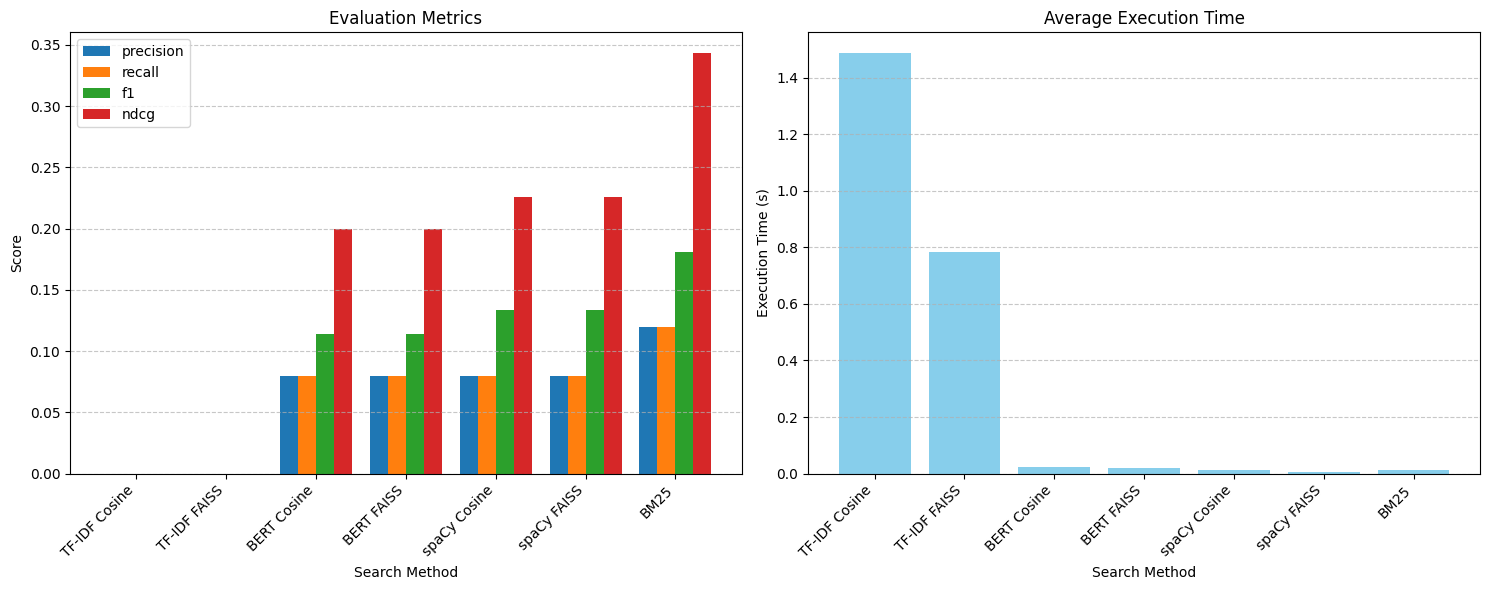

In [ ]:
# Run evaluation
evaluation_results = benchmark_search_methods(combined_df, test_queries, ground_truth_indices, search_methods)

# Plot results
plot_evaluation_results(evaluation_results)

In [ ]:
#single search sample
user_query = "Rising global temperatures affecting ocean"
bm25_results = search_bm25(user_query, bm25_index, combined_df)
print("\nBM25 Results:")
print(bm25_results[['Title', 'Abstract']])


BM25 Results:
                                                  Title  \
2491  Coupling Oceanic Observation Systems to Study ...   
2544  Decadal attribution of historic temperature an...   
2470  Forecasting the effect of heat stress index an...   
170   Non-steady state model of global temperature c...   
2171  Data-driven Global Ocean Modeling for Seasonal...   

                                               Abstract  
2491  Understanding local currents in the North Atla...  
2544  We present an alternative method of calculatin...  
2470  In this paper, we estimate the effect of heat ...  
170   We propose a non-steady state model of the glo...  
2171  Accurate ocean dynamics modeling is crucial fo...  


In [ ]:
# --------------------------
# Human Evaluation Function
# --------------------------

def human_evaluation_interface(query, search_methods, top_n=5):
    """
    Interface for human evaluation of search results

    Args:
        query: Query string
        search_methods: Dictionary with search method name as key and function as value
        top_n: Number of top results to consider
    """
    all_results = {}

    # Get results from all methods
    for method_name, search_function in search_methods.items():
        results = search_function(query, top_n=top_n)
        all_results[method_name] = results

    # Print results for evaluation
    print(f"Query: {query}\n")

    for method_name, results in all_results.items():
        print(f"\n{'-'*50}")
        print(f"Method: {method_name}")
        print(f"{'-'*50}")

        for i, (_, row) in enumerate(results.iterrows()):
            print(f"Result {i+1}:")
            print(f"Title: {row['Title']}")
            print(f"Abstract: {row['Abstract'][:200]}...\n")

    # Here you could add code to collect human ratings
    # For example, ask users to rate the relevance of each result on a scale of 1-5

    return all_results

# Example usage:
# human_evaluation_interface("Rising global temperatures affecting ocean", search_methods)

In [ ]:
human_evaluation_interface("Rising global temperatures affecting ocean", search_methods)

Query: Rising global temperatures affecting ocean


--------------------------------------------------
Method: TF-IDF Cosine
--------------------------------------------------
Result 1:
Title: Coupling Oceanic Observation Systems to Study Mesoscale Ocean Dynamics
Abstract: Understanding local currents in the North Atlantic region of the ocean is a
key part of modelling heat transfer and global climate patterns. Satellites
provide a surface signature of the temperature o...

Result 2:
Title: Data-driven Global Ocean Modeling for Seasonal to Decadal Prediction
Abstract: Accurate ocean dynamics modeling is crucial for enhancing understanding of
ocean circulation, predicting climate variability, and tackling challenges
posed by climate change. Despite improvements in t...

Result 3:
Title: Forecasting the effect of heat stress index and climate change on cloud
  data center energy consumption
Abstract: In this paper, we estimate the effect of heat stress index (a measure which
takes into a

{'TF-IDF Cosine':                                                   Title             Published  \
 2491  Coupling Oceanic Observation Systems to Study ...  2019-10-18T18:10:47Z   
 2171  Data-driven Global Ocean Modeling for Seasonal...  2024-05-24T10:23:17Z   
 2470  Forecasting the effect of heat stress index an...  2019-11-09T16:17:15Z   
 2254  A dynamical geography of observed trends in th...  2024-05-29T10:54:33Z   
 129   Towards Optimally Weighted Physics-Informed Ne...  2021-06-16T12:48:13Z   
 
                                                 Authors  \
 2491       Gautier Cosne, Guillaume Maze, Pierre Tandeo   
 2171  Zijie Guo, Pumeng Lyu, Fenghua Ling, Lei Bai, ...   
 2470                                  Vikas Ramachandra   
 2254        Bruno Buongiorno Nardelli, Daniele Iudicone   
 129   Taco de Wolff, Hugo Carrillo, Luis Martí, Naya...   
 
                                                Abstract  \
 2491  Understanding local currents in the North Atla...   
 2171  